In [1]:
import pandas as pd
import numpy as np
import itertools
import random
import math
from collections import defaultdict
from collections import Counter
import itertools
from matplotlib import pyplot as plt

# Reading data

In [2]:
alunos = pd.read_csv('alunos.csv', sep=';')
alunos.head()

,Data,Idade,Doenca
0,21/9/2019,16,sarampo
1,19/8/2006,18,meningite
2,15/1/2011,16,meningite
3,13/2/2009,17,catapora
4,19/6/2006,18,meningite


In [3]:
def pre_processing(path):
    students = pd.read_csv(path, sep=';')
    split_data = students.copy()
    complemento = students['Data'].str.split('/', expand=True)
    split_data['Dia'], split_data['Mes'], split_data['Ano'] = complemento[0], complemento[1], complemento[2]
    decades = [year[:-1]+'0s' for year in split_data['Ano']]
    split_data['Decada'] = decades
    
    split_data['FaixaEtaria'] = [None]*len(split_data)
    bins = [int(split_data['Idade'].min())-1, int(split_data['Idade'].min())+2, int(split_data['Idade'].max())+1]
    labels = [str(bins[i-1])+'-'+str(bins[i]) for i in range(1, len(bins))]
    split_data['FaixaEtaria'] = pd.cut(split_data['Idade'], bins=bins, labels=labels)
    
    split_data['RangeMaximo'] = [str(split_data['Idade'].min()-1)+'-'+str(split_data['Idade'].max()+1)]*len(split_data)
    
    split_data = split_data[['Dia', 'Mes', 'Ano', 'Decada', 'Idade', 'FaixaEtaria', 'RangeMaximo', 'Doenca']]
    
    return students, split_data

### Separating data to generalize it when necessary

In [4]:
original_data, split_data = pre_processing('alunos.csv')

In [5]:
np.unique(split_data['FaixaEtaria'])

array(['15-18', '18-21'], dtype=object)

In [6]:
split_data.head(10)

,Dia,Mes,Ano,Decada,Idade,FaixaEtaria,RangeMaximo,Doenca
0,21,9,2019,2010s,16,15-18,15-21,sarampo
1,19,8,2006,2000s,18,15-18,15-21,meningite
2,15,1,2011,2010s,16,15-18,15-21,meningite
3,13,2,2009,2000s,17,15-18,15-21,catapora
4,19,6,2006,2000s,18,15-18,15-21,meningite
5,18,5,2010,2010s,20,18-21,15-21,meningite
6,1,3,2019,2010s,20,18-21,15-21,meningite
7,5,9,2013,2010s,16,15-18,15-21,gripe
8,1,7,2012,2010s,18,15-18,15-21,catapora
9,11,3,2018,2010s,16,15-18,15-21,sarampo


In [7]:
def generalization_trees():
    date_lvl = {
        ('Dia', 'Mes', 'Ano'): 1,
        ('Mes', 'Ano'): 2,
        ('Ano'): 3,
        ('Decada'): 4
    }

    age_lvl = {
        ('Idade'): 1,
        ('FaixaEtaria'): 2,
        ('RangeMaximo'): 3
    }

    return date_lvl, age_lvl

# Definindo prioridade para agrupamentos

In [8]:
def sort_priority(all_combinations):
    gen_trees = generalization_trees()
    order = []
    for i in all_combinations:
        order.append(gen_trees[0][i[0]]+gen_trees[1][i[1]])

    A = np.array(all_combinations, dtype=object)
    B = np.array(order)
    inds = B.argsort()
    sorted_all_combinations = A[inds]
    sorted_all_combinations = sorted_all_combinations.tolist()
    
    return sorted_all_combinations

def priority_level(dataset):
    gen_trees = generalization_trees()
    periods_date = list(gen_trees[0].keys())
    periods_age = list(gen_trees[1].keys())

    all_combinations = list(itertools.product(periods_date, periods_age))
    all_combinations = sort_priority(all_combinations)
    all_combinations = [list(itertools.chain.from_iterable([[i] if(type(i) == str) else list(i) for i in list_i ])) \
                        for list_i in all_combinations]
    
    all_combinations = [i for i in all_combinations if('Idade' in i or 'FaixaEtaria' in i or 'RangeMaximo' in i or 'Decada' in i)]
    all_groups = [dataset.groupby(all_combinations[i]).groups for i in range(len(all_combinations))]
    
    return all_groups

### Função auxiliar de distância entre dois registros

In [9]:
def distance(x, y, attributes):
    D = 0
    for attr in attributes:
        if(x[attr] != y[attr]):
            D += 1
            
    return D

### Todos os agrupamentos

In [10]:
def cluster_by_priority(dataset, k):
    clusters = defaultdict(list)
    clustered = set()
    groups = priority_level(dataset)

    for i in range(len(groups)):
        for key, value in zip(groups[i].keys(), groups[i].values()):
            if len(value) >= k and  len(clustered.intersection(value)) == 0:
                # se o grupo do groupby é maior ou igual a k e nenhum dos valores já estiver agrupado
                clusters[key] = list(itertools.chain(list(set(value) - set(clustered))))
                clustered = clustered.union(clusters[key])

    return clusters, clustered

In [11]:
def all_clusters(dataset, k):
    clusters = []
    not_clustered = list(dataset.index)
    df_not_clustered = dataset.loc[not_clustered]
    
    # Criando agrupamentos até que a quantidade de tuplas que não foram agrupadas seja menor ou igual a k
    while len(not_clustered) > k:
        cluster_i, clustered_i = cluster_by_priority(df_not_clustered, k)
        not_clustered = list(set(not_clustered) - set(clustered_i))
        df_not_clustered = dataset.loc[not_clustered]
        clusters.append(cluster_i)

    # Unindo todos os agrupamentos gerados
    clusters_final = {}
    for c in clusters:
        clusters_final.update(c)    
    
    # Adicionando os clusters que não foram agrupados ao cluster mais próximo usando uma função de distância
    for i in range(len(df_not_clustered)):
        for cf in clusters_final:
            min_distance = np.inf
            distance_x_cf = distance(df_not_clustered.iloc[i], dataset.loc[clusters_final[cf][0]], df_not_clustered.columns[:-1])
            if distance_x_cf < min_distance:
                min_distance = distance_x_cf
                min_cluster = cf
                
        clusters_final[min_cluster].append(df_not_clustered.iloc[i].name)
        not_clustered.remove(df_not_clustered.iloc[i].name)
        
        # Atualizando o cluster cujo registro foi adicionado, para que a chave agora tenha o valor generalizado correspondente
        regs_in_cluster_min = clusters_final[min_cluster]        
        df_update_cluster_min = dataset.loc[regs_in_cluster_min]
        up_cluster, up_clustered = cluster_by_priority(df_update_cluster_min, len(regs_in_cluster_min))
        clusters_final.update(up_cluster)
        clusters_final.pop(min_cluster)
            
    return clusters_final, not_clustered

# k-anonimato

In [12]:
def k_anonymity(dataset, clusters):
    dataset = split_data.copy
    clusters_ = clusters.copy()
    df_list = []

    for key in clusters.keys():
        for i in clusters[key]:
            if len(key) == 4:
                year = '{}/{}/{}'.format(key[0],key[1],key[2])
            elif len(key) == 3:
                year = '{}/{}'.format(key[0],key[1])
            else:
                if 's' in key[0]:
                    decade = key[0]
                    year = decade[-3:]
                else:
                    year = key[0]
            age = key[-1]
            df_list.append([year, age, split_data.loc[i]['Doenca'] ])
    k_anomymized = pd.DataFrame(df_list, columns=['Data', 'Idade', 'Doenca'])

    return k_anomymized

### Histograma de classes de equivalência

In [13]:
def plot_histogram(clusters):
    lengths = []
    for cluster in clusters.values():
        lengths.append(len(cluster))

    counter = dict(sorted(Counter(lengths).items()))
    keys_str = [str(key) for key in counter.keys()]
    plt.bar(keys_str, counter.values())
    
    return plt.show()

### Cálculo da precisão

In [14]:
def len_HGV(atrib):
    if(atrib == 'Data'):
        return 3
    elif(atrib == 'Idade'):
        return 2
    else:
        return 'Atributo inválido.'
    
def level_tree(atrib, input_):
    if(atrib == 'Data'):
        if('s' in input_):
            return 3
        elif(input_.count('/') == 0):
            return 2
        elif(input_.count('/') == 1):
            return 1
        else:
            return 0
    elif(atrib == 'Idade'):
        if(type(input_) == int):
            return 0
        elif(type(input_) == str and (input_ == '15-18' or input_ == '18-21')):
            return 1
        else:
            return 2
    else:
        return "Atributo inválido."
    
def precision(dataset):
    sum_all = 0
    for at in dataset.columns[:-1]:
        sum_reg = 0
        for value in dataset[at]: # percorre o dataset e pega os valores de tal atributo para o registro acessado
            sum_reg += level_tree(at, value)
        sum_all += sum_reg/len_HGV(at)

    return 1-(sum_all/(len(dataset)*len(dataset.columns[:-1])))

# Chamadas de funções

len 300

Primeiras 5 linhas do dataset anonimizado com k = 2




,Data,Idade,Doenca
0,5/4/2011,18,sarampo
1,5/4/2011,18,sarampo
2,17/4/2008,15-18,catapora
3,17/4/2008,15-18,gripe
4,23/5/2009,18-21,catapora


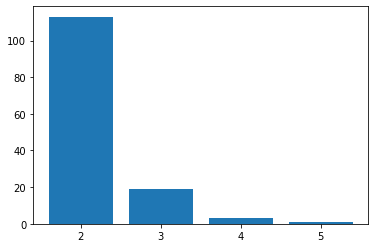

Chaves das classes de equivalência:
[('00s', '15-21'), ('1/2009', '15-21'), ('1/2010', '15-18'), ('1/2011', 16), ('1/2014', 20), ('1/2014', '15-18'), ('1/2015', 19), ('1/2015', '15-18'), ('1/2016', '18-21'), ('1/2018', '15-18'), ('10/2006', 19), ('10/2007', '15-21'), ('10/2012', 19), ('10s', 18), ('10s', 20), ('10s', '15-21'), ('11/2005', '15-18'), ('11/2007', 19), ('11/2007', '15-18'), ('11/2008', '15-18'), ('11/2012', '15-18'), ('11/2013', '15-21'), ('11/2014', '15-18'), ('11/2017', 16), ('11/2019', 19), ('17/4/2008', '15-18'), ('2/2005', 18), ('2/2005', '18-21'), ('2/2006', 16), ('2/2009', 17), ('2/2010', '15-18'), ('2/2012', 19), ('2/2015', 20), ('2/2019', '15-18'), ('2005', 16), ('2005', 19), ('2005', '15-18'), ('2006', 17), ('2006', 19), ('2006', 20), ('2006', '15-18'), ('2007', 18), ('2007', 19), ('2007', 20), ('2008', 17), ('2008', 20), ('2008', '15-18'), ('2009', 19), ('2009', 20), ('2010', 16), ('2010', 17), ('2010', 19), ('2011', 16), ('2011', 18), ('2011', 19), ('2011', 20)

,Data,Idade,Doenca
0,5/2009,15-18,meningite
1,5/2009,15-18,sarampo
2,5/2009,15-18,catapora
3,5/2009,15-18,meningite
4,2005,16,sarampo


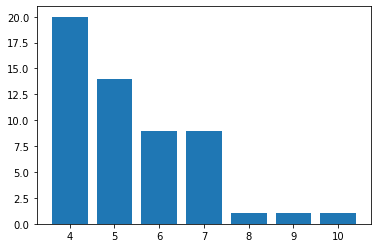

Chaves das classes de equivalência:
[('00s', 20), ('00s', '15-18'), ('10s', 17), ('10s', 20), ('2005', 16), ('2005', 18), ('2005', 19), ('2005', 20), ('2006', 16), ('2006', 18), ('2006', 19), ('2006', 20), ('2007', 18), ('2007', 19), ('2007', '15-18'), ('2008', 17), ('2008', 18), ('2008', 19), ('2009', 16), ('2009', 19), ('2009', 20), ('2009', '15-18'), ('2010', 17), ('2010', '15-18'), ('2011', 16), ('2011', 18), ('2011', 19), ('2012', 16), ('2012', 17), ('2012', 19), ('2013', 18), ('2013', '15-18'), ('2013', '18-21'), ('2014', 17), ('2014', 18), ('2014', 19), ('2014', 20), ('2015', 16), ('2015', 17), ('2015', 18), ('2015', 19), ('2015', 20), ('2016', 17), ('2016', 19), ('2017', 16), ('2017', 18), ('2017', '18-21'), ('2018', 16), ('2018', 17), ('2018', 18), ('2018', '18-21'), ('2019', 18), ('2019', 19), ('2019', '15-18'), ('5/2009', '15-18')]


Precisão: 0.6099773242630385


Tamanho médio das classes de equivalência: 5.454545454545454

--------------------------------------------------

,Data,Idade,Doenca
0,2009,20,catapora
1,2009,20,sarampo
2,2009,20,meningite
3,2009,20,gripe
4,2009,20,meningite


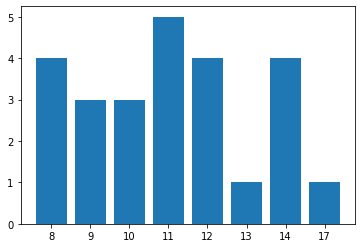

Chaves das classes de equivalência:
[('00s', '18-21'), ('2005', '15-18'), ('2005', '18-21'), ('2006', '15-18'), ('2006', '18-21'), ('2007', '15-18'), ('2007', '18-21'), ('2008', '15-18'), ('2009', 20), ('2009', '15-18'), ('2010', '15-18'), ('2011', '15-18'), ('2011', '18-21'), ('2012', 19), ('2012', '15-18'), ('2013', '15-18'), ('2014', '15-18'), ('2014', '18-21'), ('2015', '15-18'), ('2015', '18-21'), ('2016', '15-21'), ('2017', '15-18'), ('2018', '15-18'), ('2019', '15-18'), ('2019', '18-21')]


Precisão: 0.41396882494004794


Tamanho médio das classes de equivalência: 12.0

----------------------------------------------------------------------------------------------------



In [15]:
possible_k = [2, 4, 8]
for k in possible_k:
    clusters, not_clustered = all_clusters(split_data, k)
    anon = k_anonymity(alunos, clusters)
    print('len',len(anon))
    print("\nPrimeiras 5 linhas do dataset anonimizado com k = {}\n\n".format(k))
    display(anon.head())
    plot_histogram(clusters)
    print("Chaves das classes de equivalência:\n{}\n".format(list(anon.groupby(['Data', 'Idade']).groups.keys())))
    print("\nPrecisão: {}\n\n".format(precision(anon)))
    print("Tamanho médio das classes de equivalência: {}\n\n{}\n".format(len(alunos)/len(anon.groupby(by=['Data', 'Idade']).groups), '-'*100))
    anon.to_csv('{}AnonAlunos.csv'.format(k))

# l-diversidade

In [16]:
def l_diversity(dataset_, l, label):
    dataset = dataset_.copy()
    count_labels = Counter(dataset[label])

    groups = dataset.groupby(list(dataset.columns[:-1])).groups
    
    for key in groups.keys():
        df = pd.DataFrame([dataset.loc[i] for i in groups[key]])
        if l > len(df):
            print('Valor de l inválido.')
        elif len(np.unique(df[label])) < l:
            while len(np.unique(df[label])) < l:
                display(df)
                copia_count = count_labels.copy()
                most_frequent = list(df[label].value_counts().keys())[0]
                to_change = df[df[label] == most_frequent].iloc[0].name
                # retiro a possibilidade de colocar elementos que ja estão no df[label]
                for _ in np.unique(df[label]):
                    copia_count.pop(_)
                print(copia_count)
                df[label].loc[to_change] = random.choices(list(copia_count.keys()), weights=copia_count.values(), k=1)[0]
                display(df)
        for i in df.index:
            dataset.loc[i] = df.loc[i]       
    return dataset

### Cálculo do erro absoluto

In [17]:
def absolute_error(dataset_original, dataset_anon, label):
    count_labels_orig = Counter(dataset_original[label])
    count_labels_anon = Counter(dataset_anon[label])

    errors = []

    for doenca in count_labels_orig:
        errors.append(abs(count_labels_orig[doenca] - count_labels_anon[doenca]))

    return list(count_labels_anon.keys()), errors

# Chamada de funções l-diversidade

In [18]:
clusters, clustered = all_clusters(split_data, 8)
df_k_anon = k_anonymity(split_data, clusters)
groups_k_anon = df_k_anon.groupby(['Data', 'Idade']).groups

possible_l = [2, 3, 4]

for l in possible_l:
    anon = l_diversity(anon, l, 'Doenca')
    print("\nl = {}\n\n".format(l))
    groups = anon.groupby(['Data', 'Idade']).groups
    [(print('\n\nDataset após aplicar {}-diversidade.\n\n'.format(l)), display(pd.DataFrame([anon.loc[i] for i in values]).sort_values(by='Doenca'))) \
     for values in groups.values()]
    print('Erro Absoluto: {}\n\n'.format(absolute_error(alunos, anon, 'Doenca')))
    print("Tamanho médio das classes de equivalência: {}\n\n{}\n".format(len(alunos)/len(anon.groupby(by=['Data', 'Idade']).groups), '-'*100))
    anon.to_csv('{}lAnonAlunos.csv'.format(l))


l = 2




Dataset após aplicar 2-diversidade.




,Data,Idade,Doenca
266,00s,18-21,catapora
274,00s,18-21,catapora
275,00s,18-21,catapora
277,00s,18-21,catapora
269,00s,18-21,gripe
270,00s,18-21,gripe
271,00s,18-21,gripe
276,00s,18-21,gripe
267,00s,18-21,meningite
268,00s,18-21,meningite




Dataset após aplicar 2-diversidade.




,Data,Idade,Doenca
17,2005,15-18,catapora
20,2005,15-18,catapora
21,2005,15-18,catapora
18,2005,15-18,gripe
19,2005,15-18,gripe
24,2005,15-18,gripe
25,2005,15-18,gripe
28,2005,15-18,gripe
23,2005,15-18,meningite
26,2005,15-18,meningite




Dataset após aplicar 2-diversidade.




,Data,Idade,Doenca
30,2005,18-21,catapora
32,2005,18-21,catapora
35,2005,18-21,catapora
39,2005,18-21,catapora
38,2005,18-21,gripe
33,2005,18-21,meningite
34,2005,18-21,meningite
36,2005,18-21,meningite
37,2005,18-21,meningite
29,2005,18-21,sarampo




Dataset após aplicar 2-diversidade.




,Data,Idade,Doenca
45,2006,15-18,catapora
46,2006,15-18,catapora
49,2006,15-18,catapora
40,2006,15-18,gripe
44,2006,15-18,gripe
41,2006,15-18,meningite
42,2006,15-18,meningite
47,2006,15-18,meningite
48,2006,15-18,meningite
50,2006,15-18,meningite




Dataset após aplicar 2-diversidade.




,Data,Idade,Doenca
51,2006,18-21,catapora
57,2006,18-21,catapora
63,2006,18-21,catapora
55,2006,18-21,gripe
56,2006,18-21,gripe
64,2006,18-21,gripe
53,2006,18-21,meningite
60,2006,18-21,meningite
61,2006,18-21,meningite
52,2006,18-21,sarampo




Dataset após aplicar 2-diversidade.




,Data,Idade,Doenca
66,2007,15-18,catapora
69,2007,15-18,catapora
72,2007,15-18,catapora
68,2007,15-18,gripe
74,2007,15-18,gripe
65,2007,15-18,meningite
67,2007,15-18,meningite
70,2007,15-18,meningite
73,2007,15-18,meningite
71,2007,15-18,sarampo




Dataset após aplicar 2-diversidade.




,Data,Idade,Doenca
79,2007,18-21,catapora
83,2007,18-21,catapora
84,2007,18-21,catapora
81,2007,18-21,gripe
82,2007,18-21,gripe
80,2007,18-21,meningite
76,2007,18-21,sarampo
77,2007,18-21,sarampo
78,2007,18-21,sarampo




Dataset após aplicar 2-diversidade.




,Data,Idade,Doenca
85,2008,15-18,catapora
88,2008,15-18,catapora
91,2008,15-18,catapora
94,2008,15-18,catapora
95,2008,15-18,catapora
90,2008,15-18,gripe
98,2008,15-18,gripe
87,2008,15-18,meningite
92,2008,15-18,meningite
96,2008,15-18,meningite




Dataset após aplicar 2-diversidade.




,Data,Idade,Doenca
0,2009,20,catapora
3,2009,20,gripe
7,2009,20,gripe
2,2009,20,meningite
4,2009,20,meningite
5,2009,20,meningite
1,2009,20,sarampo
6,2009,20,sarampo




Dataset após aplicar 2-diversidade.




,Data,Idade,Doenca
100,2009,15-18,catapora
103,2009,15-18,catapora
106,2009,15-18,catapora
108,2009,15-18,catapora
110,2009,15-18,catapora
111,2009,15-18,catapora
101,2009,15-18,gripe
112,2009,15-18,gripe
99,2009,15-18,meningite
104,2009,15-18,meningite




Dataset após aplicar 2-diversidade.




,Data,Idade,Doenca
115,2010,15-18,catapora
119,2010,15-18,gripe
122,2010,15-18,gripe
117,2010,15-18,meningite
121,2010,15-18,meningite
113,2010,15-18,sarampo
114,2010,15-18,sarampo
116,2010,15-18,sarampo
118,2010,15-18,sarampo
120,2010,15-18,sarampo




Dataset após aplicar 2-diversidade.




,Data,Idade,Doenca
132,2011,15-18,catapora
133,2011,15-18,catapora
124,2011,15-18,meningite
125,2011,15-18,meningite
126,2011,15-18,meningite
128,2011,15-18,meningite
129,2011,15-18,meningite
123,2011,15-18,sarampo
127,2011,15-18,sarampo
130,2011,15-18,sarampo




Dataset após aplicar 2-diversidade.




,Data,Idade,Doenca
134,2011,18-21,gripe
135,2011,18-21,meningite
136,2011,18-21,meningite
137,2011,18-21,meningite
140,2011,18-21,meningite
141,2011,18-21,meningite
138,2011,18-21,sarampo
139,2011,18-21,sarampo




Dataset após aplicar 2-diversidade.




,Data,Idade,Doenca
13,2012,19,catapora
14,2012,19,gripe
10,2012,19,meningite
11,2012,19,meningite
12,2012,19,meningite
16,2012,19,meningite
8,2012,19,sarampo
9,2012,19,sarampo
15,2012,19,sarampo




Dataset após aplicar 2-diversidade.




,Data,Idade,Doenca
143,2012,15-18,catapora
144,2012,15-18,catapora
148,2012,15-18,catapora
152,2012,15-18,catapora
146,2012,15-18,gripe
149,2012,15-18,gripe
151,2012,15-18,gripe
142,2012,15-18,meningite
150,2012,15-18,meningite
145,2012,15-18,sarampo




Dataset após aplicar 2-diversidade.




,Data,Idade,Doenca
160,2013,15-18,catapora
153,2013,15-18,gripe
155,2013,15-18,gripe
156,2013,15-18,gripe
162,2013,15-18,gripe
158,2013,15-18,meningite
159,2013,15-18,meningite
161,2013,15-18,meningite
154,2013,15-18,sarampo
157,2013,15-18,sarampo




Dataset após aplicar 2-diversidade.




,Data,Idade,Doenca
163,2014,15-18,catapora
168,2014,15-18,catapora
166,2014,15-18,gripe
169,2014,15-18,gripe
172,2014,15-18,gripe
165,2014,15-18,meningite
167,2014,15-18,meningite
170,2014,15-18,meningite
174,2014,15-18,meningite
164,2014,15-18,sarampo




Dataset após aplicar 2-diversidade.




,Data,Idade,Doenca
175,2014,18-21,catapora
180,2014,18-21,catapora
183,2014,18-21,catapora
176,2014,18-21,gripe
181,2014,18-21,gripe
182,2014,18-21,gripe
178,2014,18-21,meningite
177,2014,18-21,sarampo
179,2014,18-21,sarampo




Dataset após aplicar 2-diversidade.




,Data,Idade,Doenca
184,2015,15-18,catapora
186,2015,15-18,catapora
188,2015,15-18,gripe
190,2015,15-18,gripe
191,2015,15-18,gripe
194,2015,15-18,gripe
185,2015,15-18,meningite
189,2015,15-18,meningite
192,2015,15-18,meningite
193,2015,15-18,meningite




Dataset após aplicar 2-diversidade.




,Data,Idade,Doenca
203,2015,18-21,catapora
199,2015,18-21,gripe
200,2015,18-21,gripe
202,2015,18-21,gripe
205,2015,18-21,gripe
206,2015,18-21,gripe
198,2015,18-21,meningite
201,2015,18-21,meningite
204,2015,18-21,meningite
197,2015,18-21,sarampo




Dataset após aplicar 2-diversidade.




,Data,Idade,Doenca
262,2016,15-21,catapora
263,2016,15-21,gripe
254,2016,15-21,meningite
255,2016,15-21,meningite
256,2016,15-21,meningite
261,2016,15-21,meningite
264,2016,15-21,meningite
257,2016,15-21,sarampo
258,2016,15-21,sarampo
259,2016,15-21,sarampo




Dataset após aplicar 2-diversidade.




,Data,Idade,Doenca
213,2017,15-18,catapora
219,2017,15-18,catapora
212,2017,15-18,gripe
216,2017,15-18,gripe
214,2017,15-18,meningite
218,2017,15-18,meningite
207,2017,15-18,sarampo
208,2017,15-18,sarampo
209,2017,15-18,sarampo
210,2017,15-18,sarampo




Dataset após aplicar 2-diversidade.




,Data,Idade,Doenca
221,2018,15-18,catapora
232,2018,15-18,catapora
230,2018,15-18,catapora
227,2018,15-18,catapora
229,2018,15-18,catapora
226,2018,15-18,gripe
231,2018,15-18,gripe
224,2018,15-18,meningite
236,2018,15-18,meningite
223,2018,15-18,meningite




Dataset após aplicar 2-diversidade.




,Data,Idade,Doenca
243,2019,15-18,catapora
244,2019,15-18,catapora
241,2019,15-18,gripe
242,2019,15-18,gripe
238,2019,15-18,sarampo
239,2019,15-18,sarampo
240,2019,15-18,sarampo
245,2019,15-18,sarampo




Dataset após aplicar 2-diversidade.




,Data,Idade,Doenca
248,2019,18-21,catapora
253,2019,18-21,catapora
249,2019,18-21,gripe
246,2019,18-21,meningite
247,2019,18-21,meningite
250,2019,18-21,sarampo
251,2019,18-21,sarampo
252,2019,18-21,sarampo


Erro Absoluto: (['catapora', 'sarampo', 'meningite', 'gripe'], [3, 8, 5, 6])


Tamanho médio das classes de equivalência: 12.0

----------------------------------------------------------------------------------------------------


l = 3




Dataset após aplicar 3-diversidade.




,Data,Idade,Doenca
266,00s,18-21,catapora
274,00s,18-21,catapora
275,00s,18-21,catapora
277,00s,18-21,catapora
269,00s,18-21,gripe
270,00s,18-21,gripe
271,00s,18-21,gripe
276,00s,18-21,gripe
267,00s,18-21,meningite
268,00s,18-21,meningite




Dataset após aplicar 3-diversidade.




,Data,Idade,Doenca
17,2005,15-18,catapora
20,2005,15-18,catapora
21,2005,15-18,catapora
18,2005,15-18,gripe
19,2005,15-18,gripe
24,2005,15-18,gripe
25,2005,15-18,gripe
28,2005,15-18,gripe
23,2005,15-18,meningite
26,2005,15-18,meningite




Dataset após aplicar 3-diversidade.




,Data,Idade,Doenca
30,2005,18-21,catapora
32,2005,18-21,catapora
35,2005,18-21,catapora
39,2005,18-21,catapora
38,2005,18-21,gripe
33,2005,18-21,meningite
34,2005,18-21,meningite
36,2005,18-21,meningite
37,2005,18-21,meningite
29,2005,18-21,sarampo




Dataset após aplicar 3-diversidade.




,Data,Idade,Doenca
45,2006,15-18,catapora
46,2006,15-18,catapora
49,2006,15-18,catapora
40,2006,15-18,gripe
44,2006,15-18,gripe
41,2006,15-18,meningite
42,2006,15-18,meningite
47,2006,15-18,meningite
48,2006,15-18,meningite
50,2006,15-18,meningite




Dataset após aplicar 3-diversidade.




,Data,Idade,Doenca
51,2006,18-21,catapora
57,2006,18-21,catapora
63,2006,18-21,catapora
55,2006,18-21,gripe
56,2006,18-21,gripe
64,2006,18-21,gripe
53,2006,18-21,meningite
60,2006,18-21,meningite
61,2006,18-21,meningite
52,2006,18-21,sarampo




Dataset após aplicar 3-diversidade.




,Data,Idade,Doenca
66,2007,15-18,catapora
69,2007,15-18,catapora
72,2007,15-18,catapora
68,2007,15-18,gripe
74,2007,15-18,gripe
65,2007,15-18,meningite
67,2007,15-18,meningite
70,2007,15-18,meningite
73,2007,15-18,meningite
71,2007,15-18,sarampo




Dataset após aplicar 3-diversidade.




,Data,Idade,Doenca
79,2007,18-21,catapora
83,2007,18-21,catapora
84,2007,18-21,catapora
81,2007,18-21,gripe
82,2007,18-21,gripe
80,2007,18-21,meningite
76,2007,18-21,sarampo
77,2007,18-21,sarampo
78,2007,18-21,sarampo




Dataset após aplicar 3-diversidade.




,Data,Idade,Doenca
85,2008,15-18,catapora
88,2008,15-18,catapora
91,2008,15-18,catapora
94,2008,15-18,catapora
95,2008,15-18,catapora
90,2008,15-18,gripe
98,2008,15-18,gripe
87,2008,15-18,meningite
92,2008,15-18,meningite
96,2008,15-18,meningite




Dataset após aplicar 3-diversidade.




,Data,Idade,Doenca
0,2009,20,catapora
3,2009,20,gripe
7,2009,20,gripe
2,2009,20,meningite
4,2009,20,meningite
5,2009,20,meningite
1,2009,20,sarampo
6,2009,20,sarampo




Dataset após aplicar 3-diversidade.




,Data,Idade,Doenca
100,2009,15-18,catapora
103,2009,15-18,catapora
106,2009,15-18,catapora
108,2009,15-18,catapora
110,2009,15-18,catapora
111,2009,15-18,catapora
101,2009,15-18,gripe
112,2009,15-18,gripe
99,2009,15-18,meningite
104,2009,15-18,meningite




Dataset após aplicar 3-diversidade.




,Data,Idade,Doenca
115,2010,15-18,catapora
119,2010,15-18,gripe
122,2010,15-18,gripe
117,2010,15-18,meningite
121,2010,15-18,meningite
113,2010,15-18,sarampo
114,2010,15-18,sarampo
116,2010,15-18,sarampo
118,2010,15-18,sarampo
120,2010,15-18,sarampo




Dataset após aplicar 3-diversidade.




,Data,Idade,Doenca
132,2011,15-18,catapora
133,2011,15-18,catapora
124,2011,15-18,meningite
125,2011,15-18,meningite
126,2011,15-18,meningite
128,2011,15-18,meningite
129,2011,15-18,meningite
123,2011,15-18,sarampo
127,2011,15-18,sarampo
130,2011,15-18,sarampo




Dataset após aplicar 3-diversidade.




,Data,Idade,Doenca
134,2011,18-21,gripe
135,2011,18-21,meningite
136,2011,18-21,meningite
137,2011,18-21,meningite
140,2011,18-21,meningite
141,2011,18-21,meningite
138,2011,18-21,sarampo
139,2011,18-21,sarampo




Dataset após aplicar 3-diversidade.




,Data,Idade,Doenca
13,2012,19,catapora
14,2012,19,gripe
10,2012,19,meningite
11,2012,19,meningite
12,2012,19,meningite
16,2012,19,meningite
8,2012,19,sarampo
9,2012,19,sarampo
15,2012,19,sarampo




Dataset após aplicar 3-diversidade.




,Data,Idade,Doenca
143,2012,15-18,catapora
144,2012,15-18,catapora
148,2012,15-18,catapora
152,2012,15-18,catapora
146,2012,15-18,gripe
149,2012,15-18,gripe
151,2012,15-18,gripe
142,2012,15-18,meningite
150,2012,15-18,meningite
145,2012,15-18,sarampo




Dataset após aplicar 3-diversidade.




,Data,Idade,Doenca
160,2013,15-18,catapora
153,2013,15-18,gripe
155,2013,15-18,gripe
156,2013,15-18,gripe
162,2013,15-18,gripe
158,2013,15-18,meningite
159,2013,15-18,meningite
161,2013,15-18,meningite
154,2013,15-18,sarampo
157,2013,15-18,sarampo




Dataset após aplicar 3-diversidade.




,Data,Idade,Doenca
163,2014,15-18,catapora
168,2014,15-18,catapora
166,2014,15-18,gripe
169,2014,15-18,gripe
172,2014,15-18,gripe
165,2014,15-18,meningite
167,2014,15-18,meningite
170,2014,15-18,meningite
174,2014,15-18,meningite
164,2014,15-18,sarampo




Dataset após aplicar 3-diversidade.




,Data,Idade,Doenca
175,2014,18-21,catapora
180,2014,18-21,catapora
183,2014,18-21,catapora
176,2014,18-21,gripe
181,2014,18-21,gripe
182,2014,18-21,gripe
178,2014,18-21,meningite
177,2014,18-21,sarampo
179,2014,18-21,sarampo




Dataset após aplicar 3-diversidade.




,Data,Idade,Doenca
184,2015,15-18,catapora
186,2015,15-18,catapora
188,2015,15-18,gripe
190,2015,15-18,gripe
191,2015,15-18,gripe
194,2015,15-18,gripe
185,2015,15-18,meningite
189,2015,15-18,meningite
192,2015,15-18,meningite
193,2015,15-18,meningite




Dataset após aplicar 3-diversidade.




,Data,Idade,Doenca
203,2015,18-21,catapora
199,2015,18-21,gripe
200,2015,18-21,gripe
202,2015,18-21,gripe
205,2015,18-21,gripe
206,2015,18-21,gripe
198,2015,18-21,meningite
201,2015,18-21,meningite
204,2015,18-21,meningite
197,2015,18-21,sarampo




Dataset após aplicar 3-diversidade.




,Data,Idade,Doenca
262,2016,15-21,catapora
263,2016,15-21,gripe
254,2016,15-21,meningite
255,2016,15-21,meningite
256,2016,15-21,meningite
261,2016,15-21,meningite
264,2016,15-21,meningite
257,2016,15-21,sarampo
258,2016,15-21,sarampo
259,2016,15-21,sarampo




Dataset após aplicar 3-diversidade.




,Data,Idade,Doenca
213,2017,15-18,catapora
219,2017,15-18,catapora
212,2017,15-18,gripe
216,2017,15-18,gripe
214,2017,15-18,meningite
218,2017,15-18,meningite
207,2017,15-18,sarampo
208,2017,15-18,sarampo
209,2017,15-18,sarampo
210,2017,15-18,sarampo




Dataset após aplicar 3-diversidade.




,Data,Idade,Doenca
221,2018,15-18,catapora
232,2018,15-18,catapora
230,2018,15-18,catapora
227,2018,15-18,catapora
229,2018,15-18,catapora
226,2018,15-18,gripe
231,2018,15-18,gripe
224,2018,15-18,meningite
236,2018,15-18,meningite
223,2018,15-18,meningite




Dataset após aplicar 3-diversidade.




,Data,Idade,Doenca
243,2019,15-18,catapora
244,2019,15-18,catapora
241,2019,15-18,gripe
242,2019,15-18,gripe
238,2019,15-18,sarampo
239,2019,15-18,sarampo
240,2019,15-18,sarampo
245,2019,15-18,sarampo




Dataset após aplicar 3-diversidade.




,Data,Idade,Doenca
248,2019,18-21,catapora
253,2019,18-21,catapora
249,2019,18-21,gripe
246,2019,18-21,meningite
247,2019,18-21,meningite
250,2019,18-21,sarampo
251,2019,18-21,sarampo
252,2019,18-21,sarampo


Erro Absoluto: (['catapora', 'sarampo', 'meningite', 'gripe'], [3, 8, 5, 6])


Tamanho médio das classes de equivalência: 12.0

----------------------------------------------------------------------------------------------------



,Data,Idade,Doenca
266,00s,18-21,catapora
267,00s,18-21,meningite
268,00s,18-21,meningite
269,00s,18-21,gripe
270,00s,18-21,gripe
271,00s,18-21,gripe
272,00s,18-21,meningite
273,00s,18-21,meningite
274,00s,18-21,catapora
275,00s,18-21,catapora


Counter({'sarampo': 74})


,Data,Idade,Doenca
266,00s,18-21,catapora
267,00s,18-21,meningite
268,00s,18-21,meningite
269,00s,18-21,sarampo
270,00s,18-21,gripe
271,00s,18-21,gripe
272,00s,18-21,meningite
273,00s,18-21,meningite
274,00s,18-21,catapora
275,00s,18-21,catapora


,Data,Idade,Doenca
123,2011,15-18,sarampo
124,2011,15-18,meningite
125,2011,15-18,meningite
126,2011,15-18,meningite
127,2011,15-18,sarampo
128,2011,15-18,meningite
129,2011,15-18,meningite
130,2011,15-18,sarampo
131,2011,15-18,sarampo
132,2011,15-18,catapora


Counter({'gripe': 59})


,Data,Idade,Doenca
123,2011,15-18,sarampo
124,2011,15-18,gripe
125,2011,15-18,meningite
126,2011,15-18,meningite
127,2011,15-18,sarampo
128,2011,15-18,meningite
129,2011,15-18,meningite
130,2011,15-18,sarampo
131,2011,15-18,sarampo
132,2011,15-18,catapora


,Data,Idade,Doenca
134,2011,18-21,gripe
135,2011,18-21,meningite
136,2011,18-21,meningite
137,2011,18-21,meningite
138,2011,18-21,sarampo
139,2011,18-21,sarampo
140,2011,18-21,meningite
141,2011,18-21,meningite


Counter({'catapora': 64})


,Data,Idade,Doenca
134,2011,18-21,gripe
135,2011,18-21,catapora
136,2011,18-21,meningite
137,2011,18-21,meningite
138,2011,18-21,sarampo
139,2011,18-21,sarampo
140,2011,18-21,meningite
141,2011,18-21,meningite


,Data,Idade,Doenca
238,2019,15-18,sarampo
239,2019,15-18,sarampo
240,2019,15-18,sarampo
241,2019,15-18,gripe
242,2019,15-18,gripe
243,2019,15-18,catapora
244,2019,15-18,catapora
245,2019,15-18,sarampo


Counter({'meningite': 81})


,Data,Idade,Doenca
238,2019,15-18,meningite
239,2019,15-18,sarampo
240,2019,15-18,sarampo
241,2019,15-18,gripe
242,2019,15-18,gripe
243,2019,15-18,catapora
244,2019,15-18,catapora
245,2019,15-18,sarampo



l = 4




Dataset após aplicar 4-diversidade.




,Data,Idade,Doenca
266,00s,18-21,catapora
274,00s,18-21,catapora
275,00s,18-21,catapora
277,00s,18-21,catapora
270,00s,18-21,gripe
271,00s,18-21,gripe
276,00s,18-21,gripe
267,00s,18-21,meningite
268,00s,18-21,meningite
272,00s,18-21,meningite




Dataset após aplicar 4-diversidade.




,Data,Idade,Doenca
17,2005,15-18,catapora
20,2005,15-18,catapora
21,2005,15-18,catapora
18,2005,15-18,gripe
19,2005,15-18,gripe
24,2005,15-18,gripe
25,2005,15-18,gripe
28,2005,15-18,gripe
23,2005,15-18,meningite
26,2005,15-18,meningite




Dataset após aplicar 4-diversidade.




,Data,Idade,Doenca
30,2005,18-21,catapora
32,2005,18-21,catapora
35,2005,18-21,catapora
39,2005,18-21,catapora
38,2005,18-21,gripe
33,2005,18-21,meningite
34,2005,18-21,meningite
36,2005,18-21,meningite
37,2005,18-21,meningite
29,2005,18-21,sarampo




Dataset após aplicar 4-diversidade.




,Data,Idade,Doenca
45,2006,15-18,catapora
46,2006,15-18,catapora
49,2006,15-18,catapora
40,2006,15-18,gripe
44,2006,15-18,gripe
41,2006,15-18,meningite
42,2006,15-18,meningite
47,2006,15-18,meningite
48,2006,15-18,meningite
50,2006,15-18,meningite




Dataset após aplicar 4-diversidade.




,Data,Idade,Doenca
51,2006,18-21,catapora
57,2006,18-21,catapora
63,2006,18-21,catapora
55,2006,18-21,gripe
56,2006,18-21,gripe
64,2006,18-21,gripe
53,2006,18-21,meningite
60,2006,18-21,meningite
61,2006,18-21,meningite
52,2006,18-21,sarampo




Dataset após aplicar 4-diversidade.




,Data,Idade,Doenca
66,2007,15-18,catapora
69,2007,15-18,catapora
72,2007,15-18,catapora
68,2007,15-18,gripe
74,2007,15-18,gripe
65,2007,15-18,meningite
67,2007,15-18,meningite
70,2007,15-18,meningite
73,2007,15-18,meningite
71,2007,15-18,sarampo




Dataset após aplicar 4-diversidade.




,Data,Idade,Doenca
79,2007,18-21,catapora
83,2007,18-21,catapora
84,2007,18-21,catapora
81,2007,18-21,gripe
82,2007,18-21,gripe
80,2007,18-21,meningite
76,2007,18-21,sarampo
77,2007,18-21,sarampo
78,2007,18-21,sarampo




Dataset após aplicar 4-diversidade.




,Data,Idade,Doenca
85,2008,15-18,catapora
88,2008,15-18,catapora
91,2008,15-18,catapora
94,2008,15-18,catapora
95,2008,15-18,catapora
90,2008,15-18,gripe
98,2008,15-18,gripe
87,2008,15-18,meningite
92,2008,15-18,meningite
96,2008,15-18,meningite




Dataset após aplicar 4-diversidade.




,Data,Idade,Doenca
0,2009,20,catapora
3,2009,20,gripe
7,2009,20,gripe
2,2009,20,meningite
4,2009,20,meningite
5,2009,20,meningite
1,2009,20,sarampo
6,2009,20,sarampo




Dataset após aplicar 4-diversidade.




,Data,Idade,Doenca
100,2009,15-18,catapora
103,2009,15-18,catapora
106,2009,15-18,catapora
108,2009,15-18,catapora
110,2009,15-18,catapora
111,2009,15-18,catapora
101,2009,15-18,gripe
112,2009,15-18,gripe
99,2009,15-18,meningite
104,2009,15-18,meningite




Dataset após aplicar 4-diversidade.




,Data,Idade,Doenca
115,2010,15-18,catapora
119,2010,15-18,gripe
122,2010,15-18,gripe
117,2010,15-18,meningite
121,2010,15-18,meningite
113,2010,15-18,sarampo
114,2010,15-18,sarampo
116,2010,15-18,sarampo
118,2010,15-18,sarampo
120,2010,15-18,sarampo




Dataset após aplicar 4-diversidade.




,Data,Idade,Doenca
132,2011,15-18,catapora
133,2011,15-18,catapora
124,2011,15-18,gripe
125,2011,15-18,meningite
126,2011,15-18,meningite
128,2011,15-18,meningite
129,2011,15-18,meningite
123,2011,15-18,sarampo
127,2011,15-18,sarampo
130,2011,15-18,sarampo




Dataset após aplicar 4-diversidade.




,Data,Idade,Doenca
135,2011,18-21,catapora
134,2011,18-21,gripe
136,2011,18-21,meningite
137,2011,18-21,meningite
140,2011,18-21,meningite
141,2011,18-21,meningite
138,2011,18-21,sarampo
139,2011,18-21,sarampo




Dataset após aplicar 4-diversidade.




,Data,Idade,Doenca
13,2012,19,catapora
14,2012,19,gripe
10,2012,19,meningite
11,2012,19,meningite
12,2012,19,meningite
16,2012,19,meningite
8,2012,19,sarampo
9,2012,19,sarampo
15,2012,19,sarampo




Dataset após aplicar 4-diversidade.




,Data,Idade,Doenca
143,2012,15-18,catapora
144,2012,15-18,catapora
148,2012,15-18,catapora
152,2012,15-18,catapora
146,2012,15-18,gripe
149,2012,15-18,gripe
151,2012,15-18,gripe
142,2012,15-18,meningite
150,2012,15-18,meningite
145,2012,15-18,sarampo




Dataset após aplicar 4-diversidade.




,Data,Idade,Doenca
160,2013,15-18,catapora
153,2013,15-18,gripe
155,2013,15-18,gripe
156,2013,15-18,gripe
162,2013,15-18,gripe
158,2013,15-18,meningite
159,2013,15-18,meningite
161,2013,15-18,meningite
154,2013,15-18,sarampo
157,2013,15-18,sarampo




Dataset após aplicar 4-diversidade.




,Data,Idade,Doenca
163,2014,15-18,catapora
168,2014,15-18,catapora
166,2014,15-18,gripe
169,2014,15-18,gripe
172,2014,15-18,gripe
165,2014,15-18,meningite
167,2014,15-18,meningite
170,2014,15-18,meningite
174,2014,15-18,meningite
164,2014,15-18,sarampo




Dataset após aplicar 4-diversidade.




,Data,Idade,Doenca
175,2014,18-21,catapora
180,2014,18-21,catapora
183,2014,18-21,catapora
176,2014,18-21,gripe
181,2014,18-21,gripe
182,2014,18-21,gripe
178,2014,18-21,meningite
177,2014,18-21,sarampo
179,2014,18-21,sarampo




Dataset após aplicar 4-diversidade.




,Data,Idade,Doenca
184,2015,15-18,catapora
186,2015,15-18,catapora
188,2015,15-18,gripe
190,2015,15-18,gripe
191,2015,15-18,gripe
194,2015,15-18,gripe
185,2015,15-18,meningite
189,2015,15-18,meningite
192,2015,15-18,meningite
193,2015,15-18,meningite




Dataset após aplicar 4-diversidade.




,Data,Idade,Doenca
203,2015,18-21,catapora
199,2015,18-21,gripe
200,2015,18-21,gripe
202,2015,18-21,gripe
205,2015,18-21,gripe
206,2015,18-21,gripe
198,2015,18-21,meningite
201,2015,18-21,meningite
204,2015,18-21,meningite
197,2015,18-21,sarampo




Dataset após aplicar 4-diversidade.




,Data,Idade,Doenca
262,2016,15-21,catapora
263,2016,15-21,gripe
254,2016,15-21,meningite
255,2016,15-21,meningite
256,2016,15-21,meningite
261,2016,15-21,meningite
264,2016,15-21,meningite
257,2016,15-21,sarampo
258,2016,15-21,sarampo
259,2016,15-21,sarampo




Dataset após aplicar 4-diversidade.




,Data,Idade,Doenca
213,2017,15-18,catapora
219,2017,15-18,catapora
212,2017,15-18,gripe
216,2017,15-18,gripe
214,2017,15-18,meningite
218,2017,15-18,meningite
207,2017,15-18,sarampo
208,2017,15-18,sarampo
209,2017,15-18,sarampo
210,2017,15-18,sarampo




Dataset após aplicar 4-diversidade.




,Data,Idade,Doenca
221,2018,15-18,catapora
232,2018,15-18,catapora
230,2018,15-18,catapora
227,2018,15-18,catapora
229,2018,15-18,catapora
226,2018,15-18,gripe
231,2018,15-18,gripe
224,2018,15-18,meningite
236,2018,15-18,meningite
223,2018,15-18,meningite




Dataset após aplicar 4-diversidade.




,Data,Idade,Doenca
243,2019,15-18,catapora
244,2019,15-18,catapora
241,2019,15-18,gripe
242,2019,15-18,gripe
238,2019,15-18,meningite
239,2019,15-18,sarampo
240,2019,15-18,sarampo
245,2019,15-18,sarampo




Dataset após aplicar 4-diversidade.




,Data,Idade,Doenca
248,2019,18-21,catapora
253,2019,18-21,catapora
249,2019,18-21,gripe
246,2019,18-21,meningite
247,2019,18-21,meningite
250,2019,18-21,sarampo
251,2019,18-21,sarampo
252,2019,18-21,sarampo


Erro Absoluto: (['catapora', 'sarampo', 'meningite', 'gripe'], [3, 9, 4, 6])


Tamanho médio das classes de equivalência: 12.0

----------------------------------------------------------------------------------------------------

